<a href="https://colab.research.google.com/github/sidm-23/One-Shot-Learning-on-Omniglot-data/blob/master/Omniglot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Importing all the required  modules
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.regularizers import l2
from keras import backend as K

In [0]:
def get_image_data(folder):
    
    """
    Get Training and evaluaation data for images
    It return the data in a DataFrame with multiple index
    """
    
    lang_list=[]#list of of languages
    X={}
    Y={}
    for languages in os.listdir(folder):
        if languages.startswith('.'):
            continue#ignore all hidden files
        else:
            images={}
            lang_list.append(languages)
            chars=[]
            for alphabets in os.listdir(folder+languages):
                im=[]
                chars.append(alphabets)
                for character in os.listdir(folder+languages+"/"+alphabets):
                    if(character.startswith('.')):
                        continue
                    else:
                        im.append(cv2.imread(folder+languages+"/"+alphabets+"/"+character))#append image data
                images[alphabets]=im#for each character
                Y[languages]=chars#for each language type
#             print(languages)
            X[languages]=images
            
    #After getting all data return the data in Serires and a Dataframe to easily access the data
    y=pd.Series(Y)
    x=pd.DataFrame.from_dict({(i,j): X[i][j] 
                               for i in X.keys() 
                               for j in X[i].keys()},orient='index')
    
    return x,y,lang_list

In [116]:
#testing module
print("Getting Trainind data")
x_train,y_train,languages=get_image_data('Fellowship/images_background/')
print('Getting Evaluation data')
x_val,y_val,languages_val=get_image_data('Fellowship/images_evaluation/')

Getting Trainind data
Getting Evaluation data


In [0]:
def siamese_net():
    
    """
    Define the architecture of the model which is convolution neraul network with 64 10x10 filters,
    relu -> max pool -> convolution with 128 7x7 filters, relu -> max pool -> convolution with 128 4x4 filters,
    relu -> max pool -> convolution with 256 4x4 filters.
    """
    
    def initialize_weights(shape, dtype=None ,name=None):
        """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
        """
        return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

    def initialize_bias(shape, dtype=None, name=None):
        """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
        """
        return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

    #Define Imput shape 
    input_shape=(105,105,3)
    left_input=Input(input_shape)
    right_input=Input(input_shape)

    """
    Creating a 4 layer model 
    """
    model=Sequential()
    model.add(Conv2D(filters=64,kernel_size=(10,10),activation='relu',
                 input_shape=input_shape,kernel_initializer=initialize_weights,kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())

    model.add(Conv2D(128,(7,7),activation='relu',kernel_initializer=initialize_weights,
                 bias_initializer=initialize_bias,kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())

    model.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=initialize_weights,
                 bias_initializer=initialize_bias,kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())

    model.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=initialize_weights,
                 bias_initializer=initialize_bias,kernel_regularizer=l2(2e-4)))
    model.add(Flatten())

    model.add(Dense(4096,activation='sigmoid',kernel_regularizer=l2(1e-3),kernel_initializer=initialize_weights,
         bias_initializer=initialize_bias))

    encode_l=model(left_input)
    encode_r=model(right_input)

    l1_layer=Lambda(lambda tensors:K.abs(tensors[0]-tensors[1]))
    l1_distance=l1_layer([encode_l,encode_r])

    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(l1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

    print(siamese_net.summary())
    
    return siamese_net

In [118]:
#Create and complie model
model=siamese_net()
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 105, 105, 3)  0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 105, 105, 3)  0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 4096)         38960448    input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 4096)         0           sequential_5[1][0]         

In [0]:
# Hyper parameters
evaluate_every =200 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 2000 # No. of training iterations

In [0]:
def get_batch(x):
  """
  Create batch to train the model
  """
  n_classes, n_examples= x.shape
  w, h =105,105
  categories=np.random.choice(n_classes,size=(batch_size,),replace=False)

  # initialize 2 empty arrays for the input image batch
  pairs=[np.zeros((batch_size, h, w,3)) for i in range(2)]
    
  # initialize vector for the targets
  targets=np.zeros((batch_size,))

  targets[batch_size//2:]=1
  for i in range(batch_size):
      category=categories[i]
      idx_1=np.random.randint(0,n_examples)
      pairs[0][i,:,:,:] = x.iat[category, idx_1]
      idx_2 = np.random.randint(0, n_examples)
      if i >= batch_size // 2:
              category_2 = category  
      else: 
          # add a random number to the category modulo n classes to ensure 2nd image has a different category
          category_2 = (category + np.random.randint(1,n_classes)) % n_classes
      pairs[1][i,:,:,:] = x.iat[category_2,idx_2]
    
  return pairs,targets
    

Starting training process!

 ------------- 

Train Loss: 2.288740873336792

 ------------- 

Train Loss: 1.7072113752365112

 ------------- 

Train Loss: 1.3755910396575928

 ------------- 

Train Loss: 1.1454741954803467

 ------------- 

Train Loss: 1.0046484470367432

 ------------- 

Train Loss: 0.9348121881484985

 ------------- 

Train Loss: 0.909724771976471

 ------------- 

Train Loss: 0.699389636516571

 ------------- 

Train Loss: 0.7665221691131592

 ------------- 

Train Loss: 0.7366732358932495


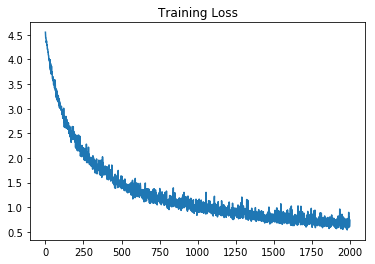

In [125]:
print("Starting training process!")
l=[]
for i in range(1, n_iter+1):
    inputs,targets = get_batch(x_train)
    loss = model.train_on_batch(inputs,targets)
    l.append(loss)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Train Loss: {0}".format(loss))
plt.title('Training Loss')
plt.plot(l)

In [0]:
def make_test_batch(N):
    """
    Create test batch
    """
    n_classes, n_examples= x_val.shape
    w, h =105,105
    categories=languages_val


    indices=m=np.random.randint(0,n_examples,size=(N,))#choose random images to be selected
    categories=np.random.randint(n_classes,size=(N,))
    test_image=np.zeros((1,w,h,3))#placehoder for test image

    targets=np.zeros((N,))
    support_set=[]
    targets[0] = 1
    true_category = categories[0]
    ex1, ex2 = np.random.choice(n_examples,replace=False,size=(2,))
    test_image[0] = np.asarray(x_val.iat[true_category,ex1])
    for c,i in zip(categories,indices):
        support_set.append(x_val.iat[c,i])
    support_set[0] = x_val.iat[true_category,ex2]
    support_set=np.array(support_set)
    targets,support_set = shuffle(targets,support_set)
    pairs = [test_image,support_set]
    return pairs,targets

In [0]:
def testing(k,N):
  """
  Used to test model for k times on N-batch size data
  """
  n_correct=0
  for i in range(k):
      inputs_t, targets_t = make_test_batch(9)
      # ImageLoader(inputs_t)
      probs = model.predict_on_batch(inputs_t)
      if np.argmax(probs) == np.argmax(targets_t):
          n_correct+=1
  percent_correct = (100.0 * n_correct / k)
  print("Got an average of "+str(percent_correct)+"% for "+str(N)+" way one-shot learning accuracy \n")
  # return percent_correct


In [0]:
def ImageLoader(imlist):
  plt.subplots()
  plt.title("Test Image")
  plt.imshow(imlist[0][0])
  print('Subset Images')
  new_img=np.zeros((480,480))
  offset=2
  for img in imlist[1]:
      # new_img=+img
      # new_image+=offset
      plt.subplots()
      plt.imshow(img)
      # plt.imshow(new_image)

In [135]:
N_way=[9,16,25,32]
for i in N_way:
  testing(32,i)

Got an average of 75.0% for 9 way one-shot learning accuracy 

Got an average of 71.875% for 16 way one-shot learning accuracy 

Got an average of 75.0% for 25 way one-shot learning accuracy 

Got an average of 78.125% for 32 way one-shot learning accuracy 



In [0]:
def get_stroke(fp):
    with open(fp,'r') as f:
        stroke_data=f.readlines()
        stroke_data=[l.strip() for l in stroke_data]
        motor=[]
        for line in stroke_data:
            if line=="START":
                stk=[]
            elif line=="BREAK":
                stk = np.array(stk)
                motor.append(stk) # add to list of strokes
                stk = [] 
            else:
                arr = np.fromstring(line,dtype=float,sep=',')
                stk.append(arr)
    return motor

In [0]:
def draw_stroke(motor):
    drawing=[d[:,0:2]for d in motor]
    for i in drawing:
        plt.subplots()
        plt.plot(i[:,0],i[:,1])

In [0]:
def get_stroke_data(folder):
    """
    Function to get stroke data and returns a dataframe in accordance to language and character 
    """
    lang_list=[]
    SX={}
    for languages in os.listdir(folder):
        if languages.startswith('.'):
            continue
        else:
            strokes={}
            lang_list.append(languages)
            for alphabets in os.listdir(folder+languages):
                if alphabets.startswith('.'):
                    continue
                else:
                    stk=[]
                    for character in os.listdir(folder+languages+"/"+alphabets):
                        if(character.startswith('.')):
                            continue
                        else:
                            stk_data=get_stroke(folder+languages+"/"+alphabets+"/"+character)
                            stk.append(stk_data)
                    strokes[alphabets]=stk
            
        print(languages)
        SX[languages]=strokes
    
    sx=pd.DataFrame.from_dict({(i,j): SX[i][j] 
                           for i in SX.keys() 
                           for j in SX[i].keys()},orient='index')
    return sx

In [0]:
stroke_train=get_stroke_data('Fellowship/strokes_background/')
stroke_test=get_stroke_data('Fellowship/strokes_evaluation/')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!unzip -uq "/content/drive/My Drive/Colab Notebooks/Fellowship"